# L3: Image generation app 🎨

HF API 키와 관련 Python 라이브러리를 로드합니다.

In [1]:
import os
import io
import IPython.display
from PIL import Image
import base64 
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
hf_api_key = os.environ['HF_API_KEY']

In [13]:
# Helper function
import requests, json
import base64
#Text-to-image endpoint
# def get_completion(inputs, parameters=None, ENDPOINT_URL=os.environ['HF_API_TTI_BASE']):
# API_URL = "https://api-inference.huggingface.co/models/runwayml/stable-diffusion-v1-5"
def get_completion(inputs, parameters=None, ENDPOINT_URL="https://api-inference.huggingface.co/models/runwayml/stable-diffusion-v1-5"): 
    headers = {
      "Authorization": f"Bearer {hf_api_key}",
      "Content-Type": "application/json"
    }   
    data = { "inputs": inputs }
    if parameters is not None:
        data.update({"parameters": parameters})

    response = requests.request("POST",
                                ENDPOINT_URL,
                                headers=headers,
                                data=json.dumps(data))
    print(response.headers)
    if response.headers['Content-Type'].startswith('image'):
        return base64.b64encode(response.content).decode('utf-8')
    else:
        return json.loads(response.content.decode("utf-8"))

## 이미지 생성 앱 구축

여기서는 `diffusers` 라이브러리를 사용하여 `runwayml/stable-diffusion-v1-.5`를 실행합니다.

### 로컬에서 실행하기

API가 아닌 로컬에서 실행하는 경우 코드는 매우 유사하게 보일 것입니다.

```py
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

def get_completion(prompt):
    return pipeline(prompt).images[0]    
```

{'Date': 'Sun, 06 Aug 2023 03:10:05 GMT', 'Content-Type': 'image/jpeg', 'Content-Length': '34427', 'Connection': 'keep-alive', 'x-sha': 'c9ab35ff5f2c362e9e22fbafe278077e196057f0', 'access-control-allow-credentials': 'true', 'x-compute-type': 'cache', 'x-request-id': 'xkUGttbY9Gi_fJKE0MFSX', 'x-compute-time': '7.148', 'vary': 'Origin, Access-Control-Request-Method, Access-Control-Request-Headers'}



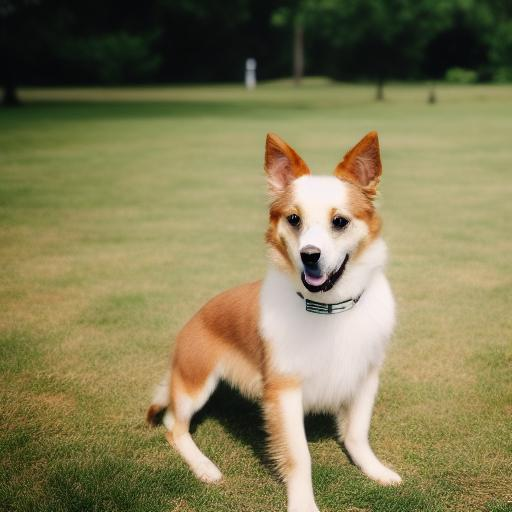

In [16]:
prompt = "a dog in a park"

result = get_completion(prompt)
# result
IPython.display.HTML(f'<img src="data:image/jpeg;base64,{result}" />')

## `gr.Interface()`로 생성

In [20]:
import gradio as gr

# PIL 이미지를 base64로 변환하는 도우미 함수입니다. 따라서 이를 API로 전송할 수 있습니다.
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt):
    output = get_completion(prompt)
    result_image = base64_to_pil(output)
    return result_image

gr.close_all()
demo = gr.Interface(
    fn=generate,
    inputs=[gr.Textbox(label="프롬프트를 입력하세요")],
    outputs=[gr.Image(label="생성된 이미지")],
    title="스테이블 디퓨전을 활용한 이미지 생성",
    # allow_flagging="never",
    examples=[
        "the spirit of a tamagotchi wandering in the city of Vienna",
        "a mecha robot in a favela"
    ]
)

demo.launch()


Running on local URL:  http://127.0.0.1:7861

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB

To create a public link, set `share=True` in `launch()`.


{'Date': 'Sun, 06 Aug 2023 03:19:53 GMT', 'Content-Type': 'image/jpeg', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'server': 'uvicorn', 'x-compute-type': 'gpu', 'access-control-expose-headers': 'x-compute-type, x-compute-time', 'x-sha': 'c9ab35ff5f2c362e9e22fbafe278077e196057f0', 'x-request-id': 'xeRUuo_NGNOkx0CKUDEur', 'access-control-allow-credentials': 'true', 'x-compute-time': '9.491', 'vary': 'Accept-Encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers', 'x-compute-characters': '58'}
{'Date': 'Sun, 06 Aug 2023 03:20:00 GMT', 'Content-Type': 'image/jpeg', 'Content-Length': '23895', 'Connection': 'keep-alive', 'x-compute-type': 'cache', 'vary': 'Origin, Access-Control-Request-Method, Access-Control-Request-Headers', 'x-sha': 'c9ab35ff5f2c362e9e22fbafe278077e196057f0', 'access-control-allow-credentials': 'true', 'x-compute-time': '9.491', 'x-request-id': 'VFV4FfVo8dlqOYfKkm5B_'}
{'Date': 'Sun, 06 Aug 2023 03:20:34 GMT', 'Content-Type': 'ima

In [21]:
demo.close()

Closing server running on port: 7861


## 고급 인터페이스 구축

In [29]:
import gradio as gr

# PIL 이미지를 base64로 변환하는 도우미 함수입니다. 따라서 이를 API로 전송할 수 있습니다.
def base64_to_pil(img_base64):
    base64_decoded = base64.b64decode(img_base64)
    byte_stream = io.BytesIO(base64_decoded)
    pil_image = Image.open(byte_stream)
    return pil_image

def generate(prompt, negative_prompt, steps, guidance, width, height):
    params = {
        "negative_prompt": negative_prompt,
        "num_inference_steps": steps,
        "guidance_scale": guidance,
        "width": width,
        "height": height
    }

    output = get_completion(prompt, params)
    pil_image = base64_to_pil(output)
    return pil_image

gr.close_all()
demo = gr.Interface(
    fn=generate,
    inputs=[
        gr.Textbox(label="프롬프트"),
        gr.Textbox(label="부정적인 프롬프트"),
        gr.Slider(label="인퍼런스 스텝", minimum=1, maximum=100, value=25,
                  info="디노이저는 몇 단계에 걸쳐 이미지의 노이즈를 제거하나요?"),
        gr.Slider(label="안내 척도", minimum=1, maximum=20, value=7,
                  info="텍스트 프롬프트가 결과에 얼마나 영향을 미치는지 제어합니다."),
        gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512),
        gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512),
    ],
    outputs=[gr.Image(label="생성된 이미지")],
    title="스테이블 디퓨전을 활용한 이미지 생성",
    description="스테이블 디퓨전으로 모든 이미지 생성",
    # allow_flagging="never",
)

demo.launch()

Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


{'Date': 'Sun, 06 Aug 2023 03:48:32 GMT', 'Content-Type': 'image/jpeg', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'x-compute-characters': '20', 'x-compute-type': 'gpu', 'x-request-id': 'CGWtHPhKvwRGIP9Pyps6S', 'access-control-allow-credentials': 'true', 'server': 'uvicorn', 'x-compute-time': '15.218', 'access-control-expose-headers': 'x-compute-type, x-compute-time', 'vary': 'Accept-Encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers', 'x-sha': 'c9ab35ff5f2c362e9e22fbafe278077e196057f0'}
{'Date': 'Sun, 06 Aug 2023 03:49:31 GMT', 'Content-Type': 'image/jpeg', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'x-compute-time': '15.843', 'server': 'uvicorn', 'x-sha': 'c9ab35ff5f2c362e9e22fbafe278077e196057f0', 'access-control-allow-credentials': 'true', 'x-compute-type': 'gpu', 'vary': 'Accept-Encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers', 'x-compute-characters': '37', 'access-control-expose-headers

In [28]:
demo.close()

Closing server running on port: 7861


## `gr.Blocks()` to the rescue!

In [33]:
with gr.Blocks() as demo:
    gr.Markdown("# 스테이블 디퓨전을 활용한 이미지 생성")
    prompt = gr.Textbox(label="프롬프트")
    with gr.Row():
        with gr.Column():
            negative_prompt = gr.Textbox(label="부정적인 프롬프트")
            steps = gr.Slider(label="인퍼런스 스텝", minimum=1, maximum=100, value=25, step=1,
                      info="디노이저는 몇 단계에 걸쳐 이미지의 노이즈를 제거하나요?")
            guidance = gr.Slider(label="안내 척도", minimum=1, maximum=20, value=7, step=1,
                      info="텍스트 프롬프트가 결과에 얼마나 영향을 미치는지 제어합니다.")
            width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
            height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
            btn = gr.Button("전송")
        with gr.Column():
            output = gr.Image(label="생성된 이미지")

    btn.click(fn=generate, inputs=[prompt, negative_prompt, steps, guidance, width, height], outputs=[output])
gr.close_all()
demo.launch()


Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


In [36]:
with gr.Blocks() as demo:
    gr.Markdown("# 스테이블 디퓨전을 활용한 이미지 생성")
    with gr.Row():
        with gr.Column(scale=4):
            prompt = gr.Textbox(label="프롬프트")
        with gr.Column(scale=1, min_width=50):
            btn = gr.Button("전송")
    with gr.Accordion("고급 옵션", open=False):
        negative_prompt = gr.Textbox(label="부정적인 프롬프트")
        with gr.Row():
            with gr.Column():
                steps = gr.Slider(label="인퍼런스 스텝", minimum=1, maximum=100, value=25, step=1,
                          info="디노이저는 몇 단계에 걸쳐 이미지의 노이즈를 제거하나요?")
                guidance = gr.Slider(label="안내 척도", minimum=1, maximum=20, value=7, step=1,
                          info="텍스트 프롬프트가 결과에 얼마나 영향을 미치는지 제어합니다.")
            with gr.Column():
                width = gr.Slider(label="Width", minimum=64, maximum=512, step=64, value=512)
                height = gr.Slider(label="Height", minimum=64, maximum=512, step=64, value=512)
    output = gr.Image(label="생성된 이미지")

    btn.click(fn=generate, inputs=[prompt, negative_prompt, steps, guidance, width, height], outputs=[output])

gr.close_all()
demo.launch()


Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


{'Date': 'Sun, 06 Aug 2023 04:09:35 GMT', 'Content-Type': 'image/jpeg', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'access-control-expose-headers': 'x-compute-type, x-compute-time', 'x-sha': 'c9ab35ff5f2c362e9e22fbafe278077e196057f0', 'server': 'uvicorn', 'x-compute-type': 'gpu', 'vary': 'Accept-Encoding, Origin, Access-Control-Request-Method, Access-Control-Request-Headers', 'x-compute-time': '9.195', 'x-compute-characters': '11', 'access-control-allow-credentials': 'true', 'x-request-id': 'nkV7aOGv-V_8BxskztZtq'}


In [37]:
gr.close_all()

Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
Closing server running on port: 7861
